In [47]:
import pandas as pd
import numpy as np

data = pd.read_csv('1612340_19800101_20221231.csv')
st = data['datetime'].iloc[0]
st
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = pd.DatetimeIndex(data.datetime)
data = data.drop(columns=['datetime']).dropna()
data

,hourly_height_STND_meters
datetime,
1980-01-01 00:00:00,1.500
1980-01-01 01:00:00,1.466
1980-01-01 02:00:00,1.405
1980-01-01 03:00:00,1.317
1980-01-01 04:00:00,1.250
...,...
2022-12-31 19:00:00,1.495
2022-12-31 20:00:00,1.511
2022-12-31 21:00:00,1.505


In [54]:
st = data.index.min()
print(st)
SL = data['hourly_height_STND_meters']
SL

# remove missing values
#SL = data[~SL.isna()]

missing = data[SL.isna()]
missing
#missing.to_csv('missing_values.csv', index=False)

1980-01-01 00:00:00


,hourly_height_STND_meters
datetime,


In [6]:
# convert datetimes to type usuable for linear regression
t = data['datetime']
# convert to date delta (https://stackoverflow.com/questions/24588437/convert-date-to-float-for-linear-regression-on-pandas-data-frame)
dd = (t - t.min())  / np.timedelta64(1,'D')
dd

datetime
1980-01-01 00:00:00        0.000000
1980-01-01 01:00:00        0.041667
1980-01-01 02:00:00        0.083333
1980-01-01 03:00:00        0.125000
1980-01-01 04:00:00        0.166667
                           ...     
2022-12-31 19:00:00    15705.791667
2022-12-31 20:00:00    15705.833333
2022-12-31 21:00:00    15705.875000
2022-12-31 22:00:00    15705.916667
2022-12-31 23:00:00    15705.958333
Name: datetime, Length: 375128, dtype: float64

<Axes: >

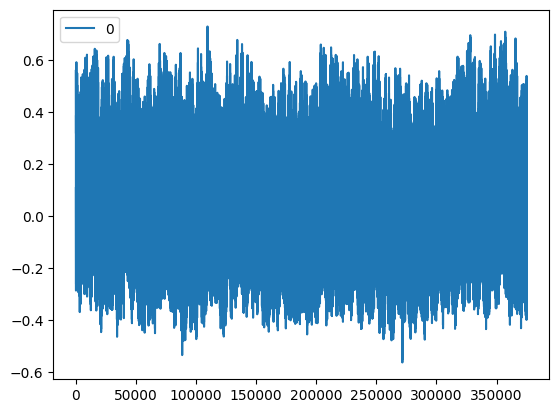

In [4]:
from scipy import signal

detrended = signal.detrend(SL)

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

In [56]:
dailyMax = data.resample('D').max()
dailyMax

,hourly_height_STND_meters
datetime,
1980-01-01,1.954
1980-01-02,1.923
1980-01-03,1.875
1980-01-04,1.780
1980-01-05,1.759
...,...
2022-12-27,1.882
2022-12-28,1.754
2022-12-29,1.685


In [57]:
yrs = data.resample('Y').max()
yrs

,hourly_height_STND_meters
datetime,
1980-12-31,2.003
1981-12-31,2.039
1982-12-31,2.009
1983-12-31,2.015
1984-12-31,2.079
1985-12-31,2.033
1986-12-31,1.990
1987-12-31,2.070
1988-12-31,2.036


In [65]:
u = data.quantile(0.98)
excess = data[data['hourly_height_STND_meters'] > u[0]]
excess

,hourly_height_STND_meters
datetime,
1980-01-01 13:00:00,1.929
1980-01-01 14:00:00,1.954
1980-01-02 14:00:00,1.923
1980-01-02 15:00:00,1.881
1980-01-03 15:00:00,1.875
...,...
2022-12-25 17:00:00,1.945
2022-12-26 16:00:00,1.922
2022-12-26 17:00:00,1.939


In [70]:

#exceedance=excess[1]-u
#exceedance
#lambda_ = len(excess) / len(yrs)

InvalidIndexError: (slice(None, None, None), 0)

<Axes: xlabel='datetime'>

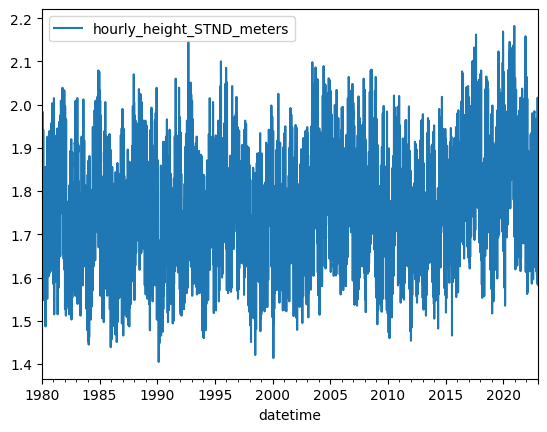

In [71]:
dailyMax.plot()

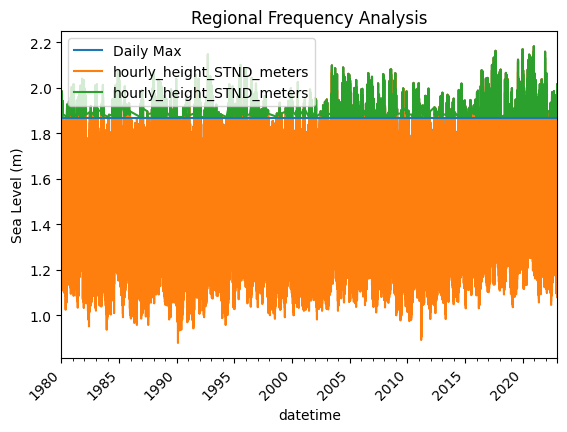

In [80]:
import matplotlib.pyplot as plt

# create a figure
fig, ax = plt.subplots()

# plot dailyMax
dailyMax.rename(columns = {'hourly_height_STND_meters':'Daily Max'}, inplace=True)
dailyMax.plot(ax=ax, title='Daily Max')
#ax.plot(dailyMax, '*-', label='Daily Max')

# plot daily_filtered
data.plot(ax=ax, title='Filtered Data')
#ax.plot(data, '*', label='Filtered Data')

# plot excess
excess.plot(ax=ax, title='Filtered Data above threshold')
#ax.plot(excess, 'o', label='Filtered Data above threshold')

# plot 98th percentile threshold
ax.axhline(u[0], linewidth=1.5)
#v = ax.axis()
#ax.plot([v[0], v[1]], [u, u], 'k-', linewidth=1.5)

# add legend, ylabel, and datetick
ax.legend()
ax.set_ylabel('Sea Level (m)')
ax.set_title('Regional Frequency Analysis')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [ ]:
dailyMax.rolling(window=2)

Ignore below this for now

In [99]:
#tt = np.vstack([dd, np.ones(len(dd))]).T
tt = np.column_stack((dd, np.ones(len(dd))))
tt
b = np.linalg.lstsq(tt, SL, rcond=None)[0]
b
slope = b[0] * 365.25 # m/yr
yh = tt * b
yh

array([[0.00000000e+00, 1.39326306e+00],
       [2.24985663e-07, 1.39326306e+00],
       [4.49971327e-07, 1.39326306e+00],
       ...,
       [8.48063209e-02, 1.39326306e+00],
       [8.48065459e-02, 1.39326306e+00],
       [8.48067709e-02, 1.39326306e+00]])

In [98]:
yh = np.array([1, 2, 3, 4, 5])
idx = 2

# Perform element-wise subtraction
yh = yh - yh[idx]

print(yh)

[-2 -1  0  1  2]


In [96]:
idx = data['datetime'].searchsorted(datetime(2000, 7, 1))
yh = yh - yh[idx] # center around midpoint
h = SL - yh

ValueError: operands could not be broadcast together with shapes (375128,) (375128,2) 

In [97]:
from datetime import datetime

# center around 2000
#idx = np.where(t == datetime(2000, 7, 1).toordinal())[0][0] # find midpoint of the year 2000 (July 1, 2000)
idx = data['datetime'].searchsorted(datetime(2000, 7, 1))
yh = yh - yh[idx] # center around midpoint
yh
#h = SL - yh # detrend timeseries

array([[-0.04042722,  0.        ],
       [-0.040427  ,  0.        ],
       [-0.04042677,  0.        ],
       ...,
       [ 0.0443791 ,  0.        ],
       [ 0.04437932,  0.        ],
       [ 0.04437955,  0.        ]])